In [1]:
import os
import sys
import requests
import numpy as np
import pandas as pd
import yfinance as yf
from bs4 import BeautifulSoup
from datetime import timedelta
from datetime import datetime

sys.path.append(os.getcwd())
from ops import *
from simulator import Simulator

%matplotlib inline

In [2]:
DATA_DIR = '/home/ezavalnyuk/git/sirius_algo/snp500_data'
if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)
if not os.path.exists(os.path.join(DATA_DIR,'spot')):
    os.mkdir(os.path.join(DATA_DIR,'spot'))

In [3]:
#parse wikipedia SNP500 page to get all tickers in index

R = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
root = BeautifulSoup(R.text, 'lxml')

tickers = []
for tr in root.find(attrs={'id':'constituents'}).find('tbody').find_all('tr')[1:]:
    tickers.append(tr.find('td').find('a').contents[0].replace('.','-'))

Исторические свечи

In [4]:
for i,ticker in enumerate(tickers):
    if os.path.exists(os.path.join(DATA_DIR,'spot',f'{ticker}.parquet')):
        continue
    sys.stdout.write(f'{i} : {ticker}')
    sys.stdout.flush()
    T = yf.Ticker(ticker)
    ticker_history = T.history(interval='1d',start='2010-01-01',end='2022-11-30')
    ticker_history.to_parquet(os.path.join(DATA_DIR,'spot',f'{ticker}.parquet'),engine='pyarrow',compression='brotli')
    sys.stdout.write('\n')
    sys.stdout.flush()

Секторы

In [5]:
sector = pd.read_csv(os.path.join(DATA_DIR,'sector.csv'),index_col=0).sector.to_dict() if os.path.exists(os.path.join(DATA_DIR,'sector.csv')) else dict()
updated = False
for i,ticker in enumerate(tickers):
    if ticker in sector:
        continue
    sys.stdout.write(f'{i} : {ticker}')
    sys.stdout.flush()
    T = yf.Ticker(ticker)
    if 'sector' in T.info:
        sector[ticker] = T.info['sector']
        updated = True
        sys.stdout.write(': success\n')
    else:
        sys.stdout.write(': error\n')
    sys.stdout.flush()
sector = pd.Series(sector)
if updated:
    sector.to_csv(os.path.join(DATA_DIR,'sector.csv'))

In [6]:
sim = Simulator(DATA_DIR)

In [7]:
close = sim.data['spot']['close']
volume = sim.data['spot']['volume']

/home/ezavalnyuk/git/sirius_algo/simulator.py:119: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  pnl = result['pnl'].loc[start_dt:].sum(axis=1).resample('1d').sum()
/home/ezavalnyuk/git/sirius_algo/simulator.py:121: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  tvr = result['tvr'].loc[start_dt:].sum(axis=1).resample('1d').sum()


avg daily tvr           = 83.53%
annualized ret          = 1.58%
ir                      = 0.0244
annualized sharpe ratio = 0.47


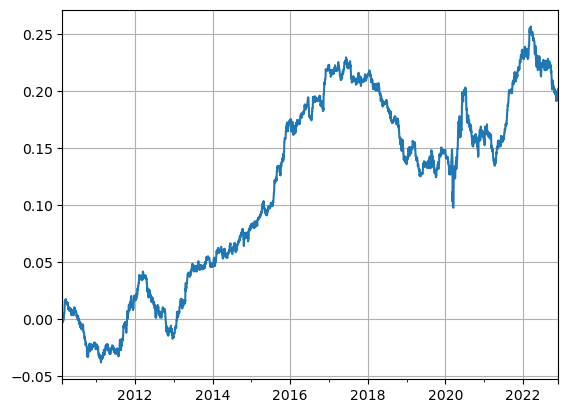

In [8]:
weights = volume/volume.rolling(5).mean()
result = sim.run_weights(weights,universe_size=400,delay=0)
sim.show_result(result)

avg daily tvr           = 56.01%
annualized ret          = 3.96%
ir                      = 0.0249
annualized sharpe ratio = 0.48


/home/ezavalnyuk/git/sirius_algo/simulator.py:119: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  pnl = result['pnl'].loc[start_dt:].sum(axis=1).resample('1d').sum()
/home/ezavalnyuk/git/sirius_algo/simulator.py:121: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  tvr = result['tvr'].loc[start_dt:].sum(axis=1).resample('1d').sum()


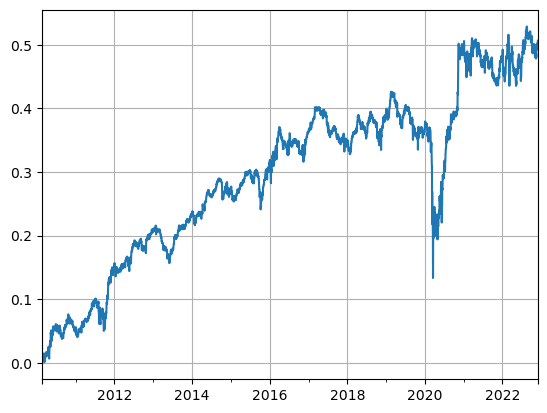

In [10]:
weights = close.rolling(5).mean()/close
result = sim.run_weights(weights,universe_size=400,delay=0)
sim.show_result(result)

avg daily tvr           = 55.95%
annualized ret          = 3.51%
ir                      = 0.028
annualized sharpe ratio = 0.53


/home/ezavalnyuk/git/sirius_algo/simulator.py:119: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  pnl = result['pnl'].loc[start_dt:].sum(axis=1).resample('1d').sum()
/home/ezavalnyuk/git/sirius_algo/simulator.py:121: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  tvr = result['tvr'].loc[start_dt:].sum(axis=1).resample('1d').sum()


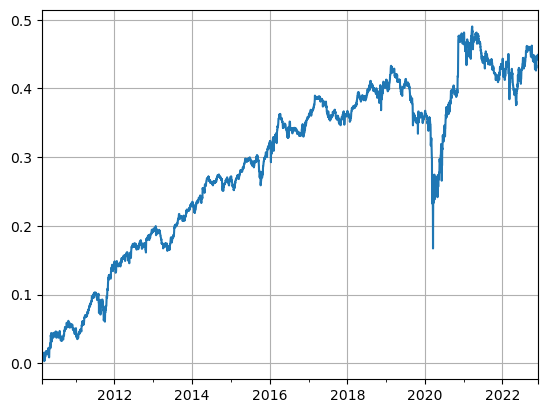

In [9]:
weights = close.rolling(5).mean()/close
weights = weights.where(sim.universe['spot'][400])
weights = group_neutralize(weights,sim.data['sector'])
result = sim.run_weights(weights,universe_size=400,delay=0)
sim.show_result(result)

In [11]:
returns = sim.data['spot']['close']/sim.data['spot']['close'].shift()-1

In [47]:
def betas(returns,window):
    market_return = returns.mean(axis=1)
    rows,indices = [],[]
    for i in range(returns.shape[0]):
        if i < window-1:
            row = pd.Series(np.nan,index=returns.columns)
        else:
            R = returns.iloc[i-window+1:i+1]
            R_market = R.mean(axis=1)
            row = R.mul(R_market,axis=0).sum(axis=0) / (R_market**2).sum()
        rows.append(row)
        indices.append(returns.index[i])
    return pd.DataFrame(rows,index=indices)

In [60]:
b = betas(returns,63)

<AxesSubplot:>

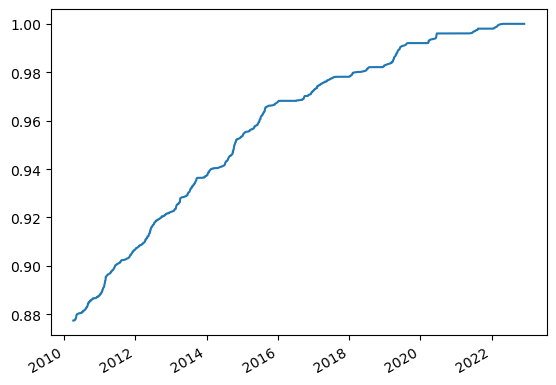

In [61]:
b.mean(axis=1).plot()

<AxesSubplot:>

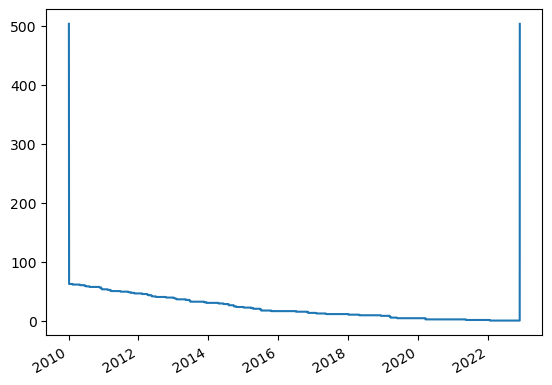

In [62]:
returns.isnull().sum(axis=1).plot()